# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 7. Решающие деревья и случайные леса.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**. Если вы строите интерактивные графики, их стоит прислать в формате html.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.




**Баллы за задание:**

* Задача 1 &mdash; 15 баллов
* Задача 2 &mdash; 50 баллов
* Задача 3 &mdash; 30 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [24]:
import scipy.stats
import warnings
import graphviz
from tqdm import tqdm_notebook

from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/trees.html">ноутбук</a> с занятия по решающим деревьям.

---
### Задача 1.

Перед обучением линейной регрессии вы могли совершать некоторые преобразования над признаками. Какие преобразования стоит совершить перед обучением решающего дерева?

В частности, ответьте на вопрос, имеет ли смысл примененять следующие преобразования:
* монотонные функции от одного признака;
> Нет, т.к. это не повлияет на разбиения в вершинах
* немонотонные функции от одного признака;
> Да, например функции вида $|t - t_0|$ помогут бороться с выбросами и уменьшат impurity *
* линейные функции от нескольких признаков;
> Да, например когда у нас есть похожие по смыслу признаки (как температура днем и температура ночью) *
* нелинейные функции от нескольких признаков;
> Да, например - определяем что-то исходя из физ. возможностей человека и было бы удобно посчитать BMI по его росту и весу *
* стандартизация признаков;
> Нет, т.к. это монотонная функция
* преобразования категориальных признаков.
> Тут эффект скорее наоборот, т.к. при малой глубине дерева выгоднее не преобразовывать кат. признаки с OneHotEncoding т.к. выгодней в вершине не исключать одно значение, а целый промежуток (ну например у нас есть поле month, и с OneHotEncoding вершина проверяла бы равен ли month 6, а без него - <= ли он 6). Ну а при достаточной глубине дерева будет +- всеравно

##### * Вполне возможно что эффект этих преобразований будет компенсирован деревом при достаточно большой глубине, т.е. это имеет смысл при малой глубине, однако подбор (гипер)параметров для функций может занять неоправданно большое время

Например, вместо/дополнительно признака $x_j$ рассматривать признак $f(x_j)$, для указанных выше типов функций.

---
### Задача 2.

Рассмотрим данные из <a href="https://miptstats.github.io/courses/ad_fivt/task6.html" target="_blank">предыдущего домашнего задания</a>. Скачайте данные и разделите их на три части &mdash; обучающую, валидационную и тестовую в соотношении 3:1:1.

In [173]:
data = pd.read_csv('data.csv')
data.drop(columns=['instant', 'dteday', 'yr', 'casual', 'registered'], inplace=True)
train, test_validate = train_test_split(data, test_size=.4)
test, validate = train_test_split(test_validate, test_size=.5)

Выполните необходимые преобразования признаков.

*Замечание.* Если в валидационной и/или тестовой частях есть "большие" выбросы, их стоит убрать. Наша модель не должна пытаться их предсказать, но в то же время выбросы вносят существенный вклад в значение метрики.

In [174]:
cat_feat_new = ['mnth', 'holiday', 'weekday', 'weathersit']
re_feat_new = ['temp', 'hum', 'windspeed']
target_feature = 'cnt'


def cut_data(_data):
    return _data[
        (_data.hum.quantile(0.01) < _data.hum) & (_data.hum < _data.hum.quantile(0.99)) &
        (_data.temp.quantile(0.01) < _data.temp) & (_data.temp < _data.temp.quantile(0.99)) &
        (_data.windspeed.quantile(0.01) < _data.windspeed) & (_data.windspeed < _data.windspeed.quantile(0.99))
        ]


encoder = OneHotEncoder(drop='first', sparse_output=False)


def prepare(_data):
    _data = cut_data(_data)
    _data_cat = encoder.fit_transform(_data[cat_feat_new])
    X_data = np.hstack([_data[re_feat_new], _data_cat])
    return X_data, _data


X_train, _train = prepare(train)
X_test, _test = prepare(test)
X_validate, _validate = prepare(validate)

Обучите решающее дерево глубины 3 и визуализируйте его. 

*Рекомендуется сохранить визуализацию в html и отправить ее вместе с решением.*

In [ ]:
model = DecisionTreeRegressor(max_depth=3, criterion='absolute_error')
model.fit(X_train, _train[target_feature])

In [176]:
def get_graphviz_graph(_model, _labels):
    dot_data = export_graphviz(
        _model, out_file=None,
        feature_names=_labels,
        class_names='Price',
        filled=True, rounded=True, special_characters=True
    )
    return graphviz.Source(dot_data)

labels = re_feat_new.copy()
for i in [
    [f'{cat_name}-{str(x)}' for x in cat_value[1:]]
    for cat_name, cat_value in zip(encoder.feature_names_in_, encoder.categories_)
]:
    labels += i

In [ ]:
get_graphviz_graph(model, labels)

**Визуализация - "first.html"**

Подберите оптимальное значение максимальной глубины дерева. Для этого обучите решающие деревья с выставленным значением соответствующего гиперпараметра и посчитайте ошибку предсказаний каждого из них на валидационной выборке. Постройте соответствующий график.

In [177]:
def make_errors_plot(errors, _range, title, xlabel):
    plt.plot(_range, errors)
    plt.title(title)
    plt.ylabel('Ошибка')
    plt.xlabel(xlabel)

In [178]:
depth_errors = []
depth_range = range(1, 30, 1)

for i in depth_range:
    model = DecisionTreeRegressor(
        criterion='absolute_error', max_depth=i,
    )
    model.fit(X_train, _train[target_feature])
    depth_errors.append(mean_squared_error(_validate[target_feature], model.predict(X_validate)) ** 0.5)

max_depth = np.argmin(depth_errors) + 1

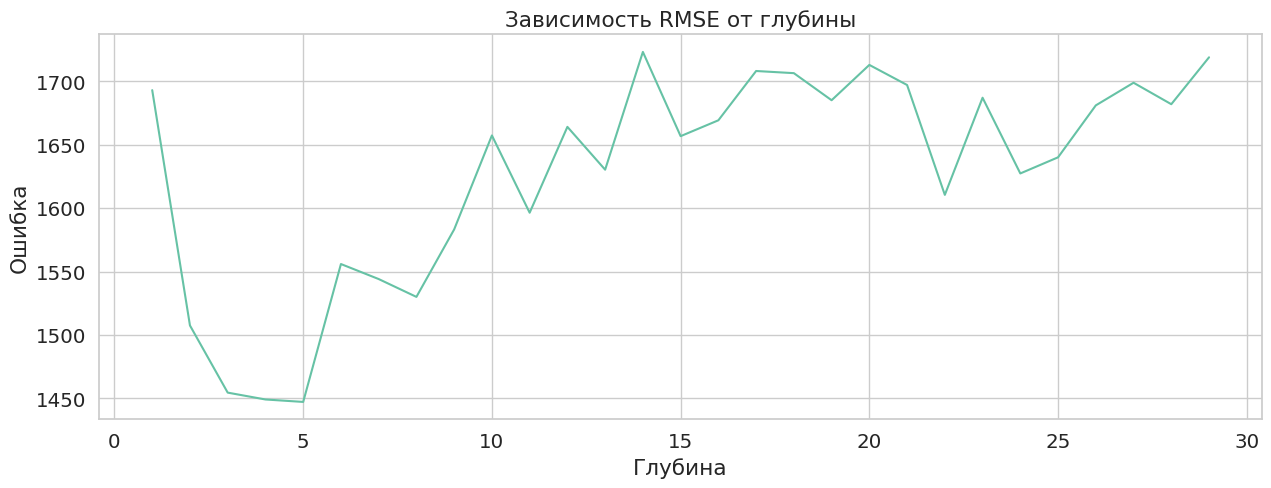

In [179]:
plt.figure(figsize=(15, 5))
make_errors_plot(
    depth_errors, depth_range, 'Зависимость RMSE от глубины', 'Глубина'
)
plt.show()

In [180]:
print(f'max_depth = {max_depth}')

max_depth = 5


Аналогичным образом подберите минимальное число объектов в листе, зафиксировав при этом подобранное значение максимальной глубины.

In [181]:
sample_errors = []
sample_range = range(1, 100, 1)

for i in sample_range:
    model = DecisionTreeRegressor(
        criterion='absolute_error', max_depth=max_depth, min_samples_leaf=i
    )
    model.fit(X_train, _train[target_feature])
    sample_errors.append(mean_squared_error(_validate[target_feature], model.predict(X_validate)) ** 0.5)

min_samples_leaf = np.argmin(sample_errors) + 1

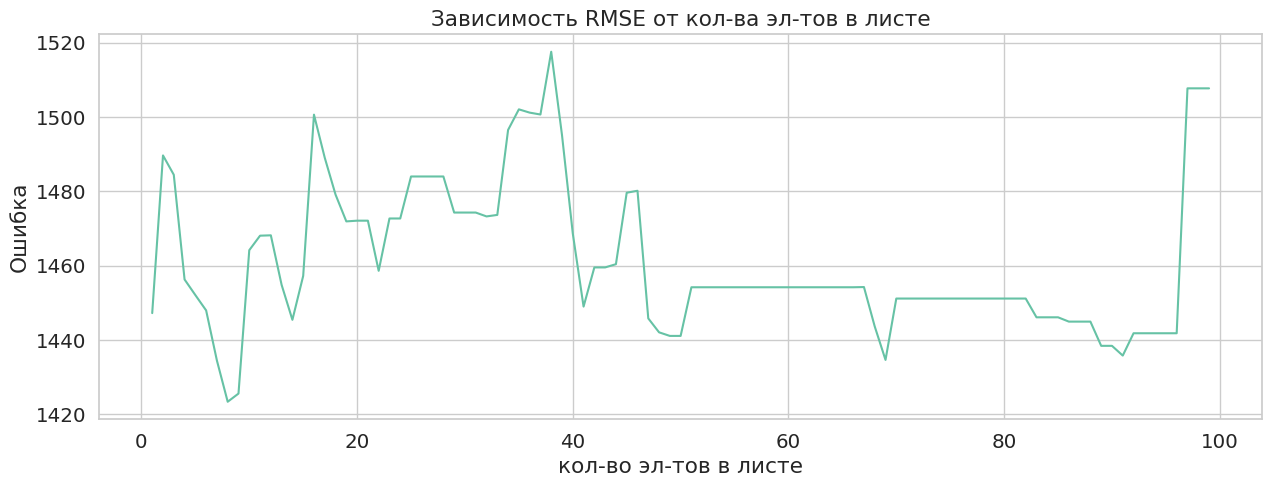

In [182]:
plt.figure(figsize=(15, 5))
make_errors_plot(
    sample_errors, sample_range, 'Зависимость RMSE от кол-ва эл-тов в листе', 'кол-во эл-тов в листе'
)
plt.show()

In [183]:
print(f'min_samples_leaf = {min_samples_leaf}')

min_samples_leaf = 8


Визуализируйте дерево при оптимальных гиперпараметрах и посчитайте его ошибку на тестовой части выборки.

In [ ]:
def print_metrics(real, predictions):
    print("RMSE: ", mean_squared_error(real, predictions) ** 0.5)
    print("MAE: ", mean_absolute_error(real, predictions))
    print("MAPE: ", mean_absolute_percentage_error(real, predictions) * 100)

In [ ]:
model = DecisionTreeRegressor(
    criterion='absolute_error', max_depth=max_depth, min_samples_leaf=min_samples_leaf
)
model.fit(X_train, _train[target_feature])

In [ ]:
get_graphviz_graph(model, labels)

**Визуализация - "second.html"**

In [185]:
print_metrics(_test[target_feature], model.predict(X_test))

RMSE:  1470.999124430084
MAE:  1205.6555555555556
MAPE:  37.46533149856486


Решающее дерево позволяет оценить *важность признаков* &mdash; некоторая величина, зависящая от того
* насколько часто тот или иной признак использовался при разбиении листа, 
* и насколько сильно при этом изменился критерий информативности.

У обученной модели значения важности признаков лежат в поле `feature_importances_`. Визуализируйте их с помощью `seaborn.barplot`.

In [186]:
def make_features_plot(_model, _labels, name):
    plt.figure(figsize=(15,5))
    sns.barplot(x=_model.feature_importances_, y=_labels)
    plt.title(f'Важность признаков для {name}')
    plt.ylabel('Признак')
    plt.xlabel('Важность')
    plt.show()

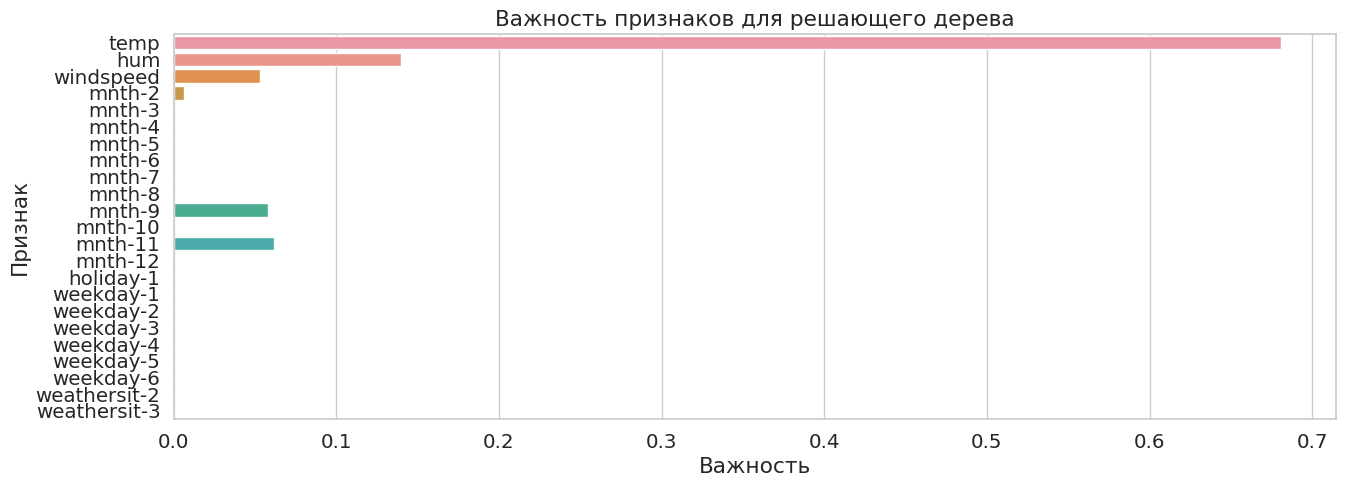

In [187]:
make_features_plot(model, labels, 'решающего дерева')

Сделайте выводы.
* При правильном (точнее не просто рандомном, не особо он и правильный) выборе параметров DecisionTreeRegressor он дает предсказания с неплохой точностью.
* При этом при создании предсказания он использует всего часть признаков и выделяет всего 1-2 действительно выжных.
* Точность предсказаний получилась чуть лучше, чем у линейной регрессии.

---
### Задача 3.

Для данных из предыдущей части обучите случайный лес на 500 деревьев.

In [ ]:
n_estimators = 500
model = RandomForestRegressor(
    n_estimators=n_estimators
)
model.fit(X_train, _train[target_feature])

Постройте график зависимости ошибки модели в зависимости от количества деревьев для обучающей и валидационной выборок.

*Замечание.* Не нужно заново обучать лес каждый раз. Используйте у *обученной* модели поле `estimators_`, это список из объектов класса `DecisionTreeRegressor`. Обратите внимание, что это приватное поле объекта, и менять его очень плохо, за такое баллы будут снижаться.

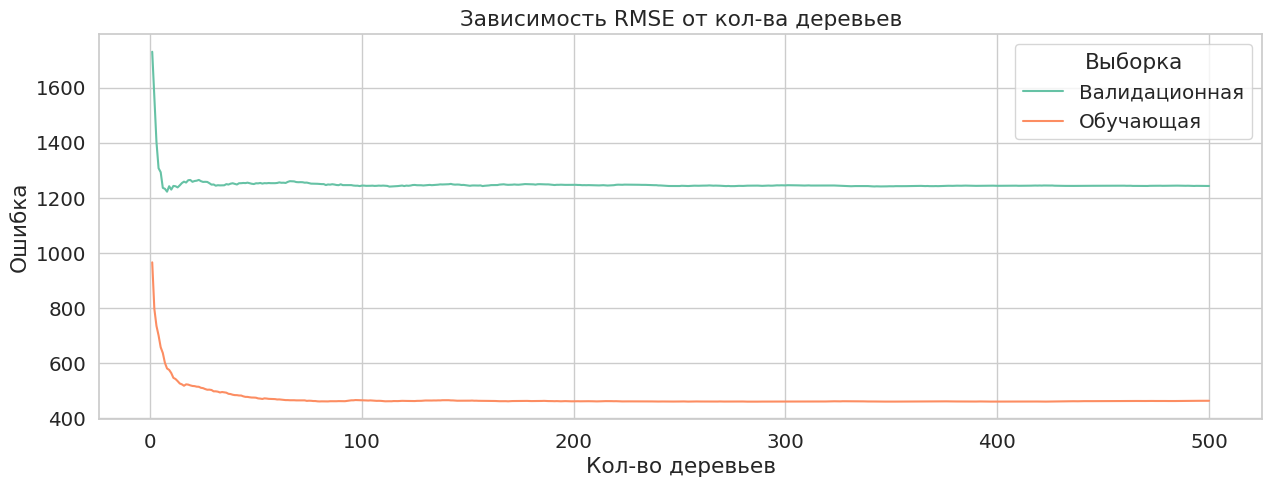

In [189]:
n_estimators_range = range(1, 501, 1)


def count_errors(x_data, _data):
    random_forest_errors = []
    for _n_estimators in n_estimators_range:
        first_n_estimators_predictions = [
            model.estimators_[i].predict(x_data) for i in range(_n_estimators)
        ]
        random_forest_errors.append(
            mean_squared_error(_data[target_feature], np.mean(first_n_estimators_predictions, axis=0)) ** 0.5
        )
    make_errors_plot(
        random_forest_errors, n_estimators_range, 'Зависимость RMSE от кол-ва деревьев', 'Кол-во деревьев'
    )


plt.figure(figsize=(15, 5))
count_errors(X_validate, _validate)
count_errors(X_train, _train)
plt.legend(['Валидационная', 'Обучающая'], title='Выборка')
plt.show()

Для леса с максимальным количеством деревьев визуализируйте
важность признаков, используя поле `feature_importances_`. 

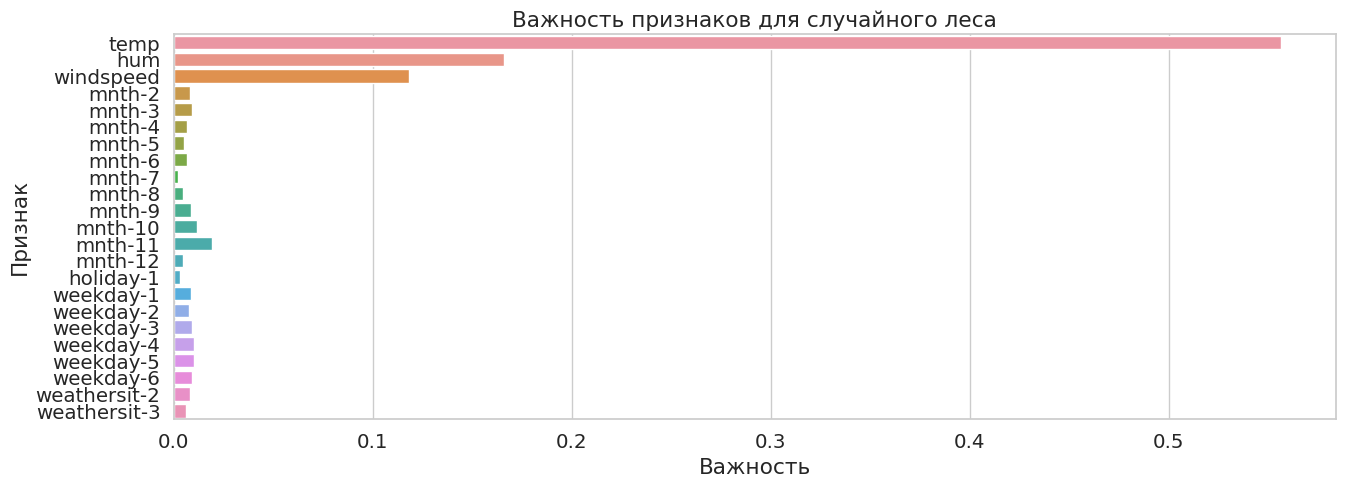

In [190]:
make_features_plot(model, labels, 'случайного леса')

In [191]:
print_metrics(_test[target_feature], model.predict(X_test))

RMSE:  1263.66530040034
MAE:  1080.9510074074074
MAPE:  34.106808780198335


Сделайте выводы.
* Случайный лес сильно переобучен, и работает заметно лучше на обучающих данных, но при этом выдает неплохую точность предсказаний (по крайней мере, лучше, чем одно дерево)
* Случайный лес использует все* доступные признаки, в отличие от дерева, но все также выделяют несколько самых важных.
*При достаточном кол-ве деревьев